# News Classification Model using Keras

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# install all packages needed

#!pip3 install sklearn --upgrade
#!pip3 install pickle --update
!pip3 install transformers
!pip3 install pymysql

In [2]:
# import all libraries needed

import pandas as pd
from pandas import read_csv
import os
import spacy
import numpy as np
import matplotlib.pyplot as plt

# nltk used for parsing and cleaning text
import nltk
import unicodedata
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from difflib import SequenceMatcher
from scipy import spatial
from itertools import combinations

# used to acccess the sql database
import pymysql
# library that helps turn dataframes into sql tables
from sqlalchemy import create_engine


import sklearn as sk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression

import pickle

## for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
current_dir = os.getcwd()
current_dir

'/content'

In [8]:
# create connection
connection = pymysql.connect(host='news-data-rdb.cqsnaejqwcpu.ap-southeast-2.rds.amazonaws.com',
                             user='admin',
                             password='badpassword1',
                             db='news_data')

In [9]:
# SQL query to retreive our data for the model
SQL_Query = pd.read_sql_query(
        '''
        select
        *
        from new_table
        ''', connection)

In [103]:
SQL_Query[SQL_Query['label'] == 0]

,news_id,text,label
1,1,flynn hillary clinton woman campus breitbart f...,0
5,5,jackie mason hollywood love trump bombed north...,0
7,7,benoît hamon wins french socialist party presi...,0
8,8,excerpts draft script donald trump ampa black ...,0
9,9,channel plan ukraine russia courtesy trump ass...,0
...,...,...,...
808939,808939,moscow cairo sign deal friday resume russian f...,0
808940,808940,transcripts clinton wall street talks released...,0
808941,808941,syrian government condemns embassy jerusalem s...,0
808942,808942,greece plays financial impact deal athens reut...,0


In [11]:
train_df = SQL_Query.sample(n=50000, random_state = 1)
train_df.reset_index(drop=True,inplace=True)
train_df

,news_id,text,label
0,270800,brief proact appoints acting reuters proact gr...,0
1,518775,tesla says agreement chinese battery maker lis...,0
2,711281,booker points boosts suns past spurs editorsno...,0
3,869205,isikoff exclusive abruptly scraps potus meet g...,1
4,584066,world number willis wins wimbledon dreamland l...,0
...,...,...,...
49995,467174,italian mafia stronghold women soccer players ...,0
49996,599812,brief ourpalm profit rises percent april reute...,0
49997,567333,brief convano announces mothers april march re...,0
49998,298928,refugees seek asylum geneva reuters refugee ag...,0


In [78]:
train_df[train_df['label'] == 0]

,news_id,text,label
0,270800,brief proact appoints acting reuters proact gr...,0
1,518775,tesla says agreement chinese battery maker lis...,0
2,711281,booker points boosts suns past spurs editorsno...,0
4,584066,world number willis wins wimbledon dreamland l...,0
6,343803,chicago blackhawks playerwatch artemi panarin ...,0
...,...,...,...
49995,467174,italian mafia stronghold women soccer players ...,0
49996,599812,brief ourpalm profit rises percent april reute...,0
49997,567333,brief convano announces mothers april march re...,0
49998,298928,refugees seek asylum geneva reuters refugee ag...,0


In [12]:
test_df = SQL_Query.sample(n=10000, random_state = 1)
test_df.reset_index(drop=True,inplace=True)
test_df

,news_id,text,label
0,270800,brief proact appoints acting reuters proact gr...,0
1,518775,tesla says agreement chinese battery maker lis...,0
2,711281,booker points boosts suns past spurs editorsno...,0
3,869205,isikoff exclusive abruptly scraps potus meet g...,1
4,584066,world number willis wins wimbledon dreamland l...,0
...,...,...,...
9995,321023,orleans saints playerwatch delvin breaux misse...,0
9996,925456,asyounotwish bothered muslims feel trump rule ...,1
9997,885461,weneedtrump trump rallies little different hil...,1
9998,249932,brief smart final stores reports financial res...,0


In [80]:
test_df[test_df['label'] == 1]

,news_id,text,label
3,869205,isikoff exclusive abruptly scraps potus meet g...,1
5,822789,dbhnbuckhead imarchwithlinda dopey liberals ex...,1
10,20422,happened hillary supporting professor decided ...,1
21,923304,blackpounduk claudiawebbe umojaisourmight http...,1
26,828469,norleansdaily live boulevard waggaman close fi...,1
...,...,...,...
9975,856691,easterin words candy hangover progress,1
9979,857293,ocamericans clinton manufactured fakenews msnb...,1
9996,925456,asyounotwish bothered muslims feel trump rule ...,1
9997,885461,weneedtrump trump rallies little different hil...,1


In [9]:
#SQL_Query.drop(index=list(test_df.index.values) ,inplace=True)
#SQL_Query.reset_index(drop=True,inplace=True)

In [13]:
#news_sql_df.to_csv(f'{current_dir}/drive/MyDrive/colab_data/news_sql_df.csv', index=False)

NameError: ignored

In [ ]:
#news_sql_df = pd.read_csv(f'{current_dir}/drive/MyDrive/colab_data/news_sql_df.csv', index_col=False)

In [ ]:
#news_sql_df

,news_id,text,label
0,0,house aide comey letter jason chaffetz tweeted...,1
1,1,flynn hillary clinton woman campus breitbart f...,0
2,2,truth fired truth fired october tension intell...,1
3,3,civilians killed single airstrike identified v...,1
4,4,iranian woman jailed fictional unpublished sto...,1
...,...,...,...
19995,19995,rembrandt proves chapter genesis rembrandt pro...,1
19996,19996,obama rising west antichrist obama rising west...,1
19997,19997,planet nibiru slovakia planet nibiru slovakia ...,1
19998,19998,book alien races exposed book alien races expo...,1


In [ ]:
# Obtain the total words present in the dataset
list_of_words = []
for i in news_sql_df.text:
  words = i.split(' ')
  for j in words:
      list_of_words.append(j)

In [ ]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

118348

In [ ]:
# split data into test and train 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(news_sql_df.text.to_list(), news_sql_df.label.to_list(), test_size = 0.1)

In [ ]:
vectorizer = TfidfVectorizer(analyzer = 'word',
                            input = 'content',
                            lowercase = True,
                            token_pattern = '(?u)\\b\\w\\w+\\b',
                            min_df = 3,
                            ngram_range = (1,1))

In [ ]:
vectorizer.fit(x_train)

x_train = vectorizer.transform(x_train).toarray() # shape - (3,6)
x_train = x_train[:, :, None] # shape - (3,6,1) since LSTM cells expects ndims = 3

x_test = vectorizer.transform(x_test).toarray() # shape - (3,6)
x_test = x_test[:, :, None] # shape - (3,6,1) since LSTM cells expects ndims = 3

In [ ]:
# turn binary labels intp a numpy array
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

## Model

In [ ]:
# Sequential Model
model = Sequential()

# embeddidng layer to do PCA 
# total_words = defined the total number of vocabs 
model.add(Embedding(total_words, output_dim = 64))

# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(64)))

# Dense layers
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          7574272   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7,648,641
Trainable params: 7,648,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model
#  validation_split = 0.1, use 10% of the data for cross validation
model.fit(x_train, y_train, batch_size = 16, epochs = 1)

   1/1125 [..............................] - ETA: 104:31:44 - loss: 0.6945 - acc: 0.3750

In [ ]:
# make prediction
pred = model.predict(x_test)

In [ ]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [ ]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

### Transformer Library

Test of transformer 

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

In [ ]:
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'

model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
tokens = tokenizer.tokenize('this is a new sentence')
token_ids = tokenizer(tokens)

In [ ]:
token_ids

In [ ]:
classifier = pipeline('zero-shot-classification')

In [ ]:
input = 'Trump was shot in the head this morning'
res = classifier(input, candidate_labels = ['reliable news', 'fake news'])

In [ ]:
res

{'labels': ['news', 'fake news'],
 'scores': [0.9644107818603516, 0.03558921441435814],
 'sequence': 'Trump was shot in the head this morning'}

## Actual Model

In [13]:
#Activating the GPU
# Main menu->Runtime->Change Runtime Type
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [14]:
#Installing the Hugging Face PyTorch Interface for Bert
# !pip install pytorch-pretrained-bert pytorch-nlp
!pip install -q transformers

In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [16]:
# Specifying CUDA as the device for Torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [17]:
# Creating sentence, label lists and adding Bert tokens
sentences = train_df.text.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = train_df.label.values

In [18]:
#Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'brief', 'pro', '##act', 'appoint', '##s', 'acting', 'reuters', 'pro', '##act', 'group', 'jason', 'clark', 'chosen', 'resign', 'position', 'february', 'board', 'decided', 'appoint', 'peter', 'ja', '##ves', '##tad', 'acting', 'source', 'text', 'e', '##iko', '##n', 'company', 'coverage', 'g', '##dy', '##nia', 'news', '##room', '[SEP]']


In [34]:
# Processing the data
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [35]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [36]:
# splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [37]:
# Converting all the data into torch tensors
# Torch tensors are the required datatype for our model

# x train
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

# y train
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

# 
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [38]:
# Selecting a Batch Size and Creating and Iterator
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [39]:
# Bert Configuration
# Initializing a BERT bert-base-uncased style configuration
# Transformer Installation
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers
  
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [40]:
# Loading the Hugging Face Bert Uncased Base Model 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [41]:
# optimizer Grouped Parameters
# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

In [42]:
# the Hyperparemeters for the Training Loop 
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [43]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [44]:
import torch
torch.cuda.empty_cache()

In [45]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1386 MB |   13439 MB |   60958 MB |   59572 MB |\n|       from large pool |    1385 MB |   13436 MB |   60947 MB |   59562 MB |\n|       from small pool |       1 MB |       3 MB |      11 MB |       9 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    1386 MB |   13439 MB |   60958 MB |   59572 MB |\n|       from large pool |    1385 MB |   13436 MB |

In [46]:
# The Training Loop
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.044832345554324846


Epoch:  25%|██▌       | 1/4 [16:59<50:57, 1019.23s/it]

Validation Accuracy: 0.9892172523961661
Train loss: 0.01803173258663156


Epoch:  50%|█████     | 2/4 [34:09<34:11, 1025.93s/it]

Validation Accuracy: 0.9906150159744409
Train loss: 0.007381332644834526


Epoch:  75%|███████▌  | 3/4 [51:17<17:06, 1026.77s/it]

Validation Accuracy: 0.9914137380191693
Train loss: 0.002866848038857151


Epoch: 100%|██████████| 4/4 [1:08:24<00:00, 1026.25s/it]

Validation Accuracy: 0.9920127795527156


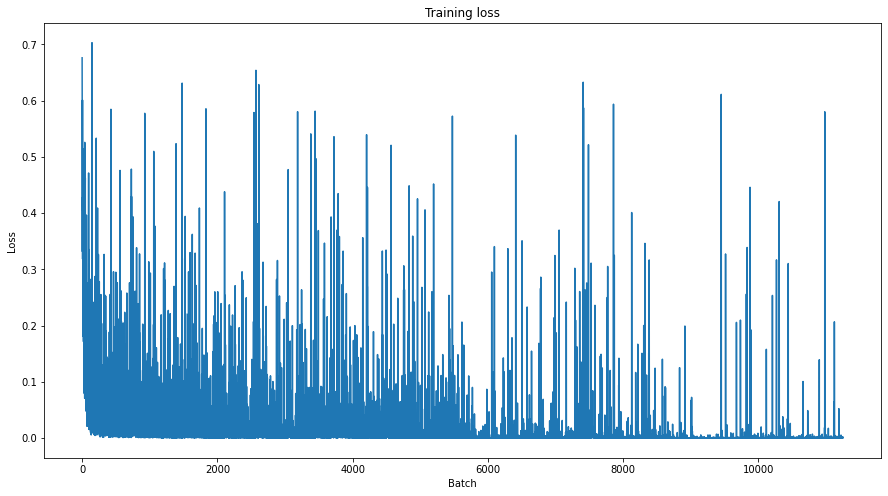

In [47]:
#Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

### Test our model onb new data

In [48]:
# Create sentence and label lists
sentences = test_df.text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = test_df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 16  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [50]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [55]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [56]:
#@title Matthew's Evaluation on the Whole Dataset
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.9952244690268817

In [ ]:
'''
## How to save a model

# vectorizer
https://stackoverflow.com/questions/64550503/huggingface-saving-tokenizer
BASE_MODEL = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.save_pretrained("./models/tokenizer/")
tokenizer2 = DistilBertTokenizer.from_pretrained("./models/tokenizer/")


# model
https://huggingface.co/docs/transformers/model_sharing
pt_model = DistilBertForSequenceClassification.from_pretrained("path/to/awesome-name-you-picked", from_tf=True)
pt_model.save_pretrained("path/to/awesome-name-you-picked")



https://stackoverflow.com/questions/64001128/load-a-pre-trained-model-from-disk-with-huggingface-transformers
# python
from transformers import BertTokenizer
# tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer = BertTokenizer.from_pretrained("/opt/word_embeddings/bert-base-uncased/")
'''

In [58]:
tokenizer.save_pretrained(f"{current_dir}/drive/MyDrive/colab_data/tokenizer_50k")

('/content/drive/MyDrive/colab_data/tokenizer_50k/tokenizer_config.json',
 '/content/drive/MyDrive/colab_data/tokenizer_50k/special_tokens_map.json',
 '/content/drive/MyDrive/colab_data/tokenizer_50k/vocab.txt',
 '/content/drive/MyDrive/colab_data/tokenizer_50k/added_tokens.json')

In [59]:
model.save_pretrained(f"{current_dir}/drive/MyDrive/colab_data/model_50k_128")

In [61]:
tokenizer2 = BertTokenizer.from_pretrained(f"{current_dir}/drive/MyDrive/colab_data/tokenizer_50k")

In [62]:
model2 = BertForSequenceClassification.from_pretrained(f"{current_dir}/drive/MyDrive/colab_data/model_50k_128")

In [63]:
model2

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [73]:
import torch.nn.functional as F

In [100]:
#import torch
#from transformers import AutoTokenizer, AutoModelForSequenceClassification

# read in trained tokenizer and model
tokenizer2 = BertTokenizer.from_pretrained(f"{current_dir}/drive/MyDrive/colab_data/tokenizer_50k")
model2 = BertForSequenceClassification.from_pretrained(f"{current_dir}/drive/MyDrive/colab_data/model_50k_128")
sequences = ["hillary clinton eats dead babies"]

# tokenize text input
tokens = tokenizer2(sequences, padding=True, truncation=True, return_tensors="pt")

In [101]:
with torch.no_grad():
  # make predictions
  output = model2(**tokens)
  print(output)

  # using a softmax activation function get discrete predictions
  predictions = F.softmax(output.logits, dim=1)
  labels = torch.argmax(predictions, dim=1)

  # using a sigmoid function get continous predictions 
  labels1 = torch.sigmoid(predictions)
  print(labels)
  print(labels1)

SequenceClassifierOutput(loss=None, logits=tensor([[-3.8595,  3.7022]]), hidden_states=None, attentions=None)
tensor([[5.1970e-04, 9.9948e-01]])
tensor([1])
tensor([[0.5001, 0.7310]])
